## Simulation for biallelic dynamics of SCN1A

In [1]:
# The following section only needs to be executed when running off of google drive

# from google.colab import drive
# drive.mount('/content/drive')

# This needs to be run only once at the beginning to access the models
#-------------------------------------------------------------------------------
!pip install --upgrade git+https://github.com/roschkoenig/SodMod.git@Single_Cell_Sim


  Cloning https://github.com/roschkoenig/SodMod.git (to revision Single_Cell_Sim) to /tmp/pip-req-build-_lv0vhzw
  Running command git clone -q https://github.com/roschkoenig/SodMod.git /tmp/pip-req-build-_lv0vhzw
  Running command git checkout -b Single_Cell_Sim --track origin/Single_Cell_Sim
  Switched to a new branch 'Single_Cell_Sim'
  Branch 'Single_Cell_Sim' set up to track remote branch 'Single_Cell_Sim' from 'origin'.
  Created wheel for sodmod: filename=sodmod-0.1-cp36-none-any.whl size=9876 sha256=e1e0965429b32074cdcf1fefc89d5b8a21ee3cff04d5e0af921987043d34e834
  Stored in directory: /tmp/pip-ephem-wheel-cache-yyqojojg/wheels/25/8a/db/fb8c9e25d5464a664514bd9bca7d2997503c64069ae1f3d291
Successfully built sodmod
  Found existing installation: sodmod 0.1
    Uninstalling sodmod-0.1:
      Successfully uninstalled sodmod-0.1


In [0]:
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
from scipy.integrate import odeint
from torch import multiprocessing as mp
from itertools import repeat
from IPython.display import set_matplotlib_formats
from google.colab import files

import sodmod as sm
from sodmod import params as pr
from sodmod import cells as cl

In [0]:
# Manual definitions
#===============================================================================
# Simulations
#-------------------------------------------------------------------------------
V0         = -80
steps      = 150                         # Number of simulations to be ru
ctyp       = 'IN'                        # Cell type to be used 'IN', 'PY', 'RE'
conds      = ['WT37', 'AS37', 'TI37']    # Conditions to be modelled
cols       = ['k', 'b', 'r']             # Colours for plotting 
doparallel = True                        # Run simulations in parallel if possible

paradigm   = 'ramp'                      # Pattern of current injection in sim

# Plotting 
#-------------------------------------------------------------------------------
ptype     = 'phase'                       # 'time', 'phase', 'bifurcation'   
T          = np.linspace(0,1000,10000)    # Time course of simulations

# Initial conditions
#-------------------------------------------------------------------------------
np.random.seed(1000)


################################## ODE Solver ##################################

#===============================================================================
# Simulation executor
#===============================================================================
def runsim(i_scl, conds, cell, V0, Y0 = None, paradigm='constant'):
  Vy    = {}

  # Run simulation across conditions
  #-------------------------------------------------------------------------------  
  for ci in range(len(conds)):
    par       = pr.params(conds[ci], i_scl, ctyp, paradigm)
    if Y0 == None:  
      y0    = np.random.rand(len(par['snames']))
      y0[0] = V0
    else:           y0 = Y0[conds[ci]][-1,:]
    Vy.update({conds[ci]:odeint(cell, y0, T, args=(par,))})

  return Vy


############################### Plotting Routines ##############################
#===============================================================================
# Time series plots
#===============================================================================
def plot_timeseries(Vy, I_scl, ctyp, Nplots = 0):

  if Nplots == 0: Nplots = len(Vy)
  conds = list(Vy[0].keys())

  # Set up plot
  #--------------------------------------------------------------------
  fig, ax = plt.subplots(Nplots,1, figsize=(12, Nplots*6))
  plotid  = 0

  for i in range(0,len(Vy),round(len(Vy)/Nplots)):
    
    for ci in range(len(conds)):
      cond = conds[ci]
      V    = Vy[i][cond][:,0]

      # Do the plotting
      #------------------------------------------------------------
      if Nplots == 1: 
        ax.plot(T, V-ci*100, cols[ci], label=conds[ci])
        ax.set_title("Max Input current " + str(I_scl))
        ax.legend()
      else:
        ax[plotid].plot(T, V-ci*100, cols[ci], label = conds[ci]) 
        ax[plotid].set_title("Input current" + str(I_scl[i]))
        ax[plotid].legend()

    plotid = plotid + 1

#===============================================================================
# Phase space plots
#===============================================================================
def plot_phasespace(Vy, I_scl, ctyp, states = ['Vm', 'm_Na'], Nplots = 0):

  if Nplots == 0: Nplots = len(Vy)
  conds = list(Vy[0].keys())
  
  # Set up plot
  #--------------------------------------------------------------------
  fig, ax = plt.subplots(1,len(conds), figsize=(12*len(conds), 12))
  testpar = pr.params(typ = ctyp)

  for ci in range(len(conds)):
    if ci == 0: cmap = plt.get_cmap('Greys')
    if ci == 1: cmap = plt.get_cmap('Blues')
    if ci == 2: cmap = plt.get_cmap('Reds')
    cmap = cmap(np.linspace(0,1,Nplots))

    for i in range(0,len(Vy),round(len(Vy)/Nplots)):

      cond = conds[ci]
      s0   = Vy[i][cond][3000:7000,testpar["snames"].index(states[0])]
      s1   = Vy[i][cond][3000:7000,testpar["snames"].index(states[1])]

      # Do the plotting
      #------------------------------------------------------------
      ax[ci].plot(s0, s1, cols[ci], color=cmap[i,:]) 
      ax[ci].set_title(cond + "Input current " + str(I_scl[i]))
  
#===============================================================================
# Bifurcation plots
#===============================================================================
def plot_bifurcation(Vy_fwd, Vy_bwd, I_fwd, I_bwd, ctyp, Nplots = None, direction = [0,1]):
  if Nplots == None: Nplots = len(Vy_fwd)
  conds  = list(Vy_fwd[0].keys())

  # Set up plot
  #--------------------------------------------------------------------
  fig, ax = plt.subplots(len(conds),1, figsize=(24,6*len(conds)))
  testpar = pr.params(typ = ctyp)

  plotid = 0
  for ci in range(len(conds)):
    for i in range(0,len(Vy_fwd),round(len(Vy_fwd)/Nplots)):

      cond = conds[ci]
      f    = np.zeros([2,1])
      b    = np.zeros([2,1])
      i_fwd    = np.multiply([1,1],np.log(I_fwd[i]))
      i_bwd    = np.multiply([1,1],np.log(I_bwd[i]))  

      f[0] = np.min(Vy_fwd[i][cond][4000:10000,0])
      f[1] = np.max(Vy_fwd[i][cond][4000:10000,0])

      b[0] = np.min(Vy_bwd[i][cond][4000:10000,0])
      b[1] = np.max(Vy_bwd[i][cond][4000:10000,0])

      # Do the plotting
      #------------------------------------------------------------

      if 0 in direction:  ax[plotid].scatter(i_fwd, f, color=cols[ci])
      if 1 in direction:  ax[plotid].scatter(i_bwd, b, color=cols[ci], facecolor='none') 

    plotid = plotid + 1

In [4]:
################################## Run ODE #####################################

if paradigm == 'ramp':
  Vy       = []
  i_scl    = np.exp(6)     # Run all the way up to maximum value
  Vy.append( runsim(i_scl, conds, getattr(cl, ctyp), V0, paradigm=paradigm) )

# # Define conditions to be tested
# #-------------------------------------------------------------------------------
# I_scl = np.exp(np.arange(-2,6,6/steps))      # Input currents to be modelled
# cell   = getattr(cl, ctyp)

# # Parallel execution (CPU based)
# #-------------------------------------------------------------------------------
# if doparallel:
#   p      = mp.Pool(len(I_scl))
#   Vy     = p.starmap(runsim, zip(I_scl, repeat(conds), repeat(cell), repeat(V0)))

# # Looped execution (for bifurcation analysis)
# #-------------------------------------------------------------------------------
# else: 
#   print('Running forward simulation')
#   Vy_fwd = []
#   I_fwd  = []
#   for i in I_scl:
#     if len(Vy_fwd) == 0:  Vy_fwd.append(runsim(i, conds, cell, V0))
#     else:                 Vy_fwd.append(runsim(i, conds, cell, V0, Vy_fwd[-1]))
#     I_fwd.append(i)
  
#   print('Running backward simulation')
#   Vy_bwd = []
#   I_bwd  = []
#   for i in np.flip(I_scl):
#     if len(Vy_bwd) == 0:  Vy_bwd.append(runsim(i, conds, cell, V0))
#     else:                 Vy_bwd.append(runsim(i, conds, cell, V0, Vy_bwd[-1]))
#     I_bwd.append(i)  

#   Vy    = Vy_fwd
#   I_scl = I_fwd
  

/usr/local/lib/python3.6/dist-packages/sodmod/chans.py:12: RuntimeWarning: invalid value encountered in double_scalars
  alpha_m  = (-0.32*(Vm-p['Vt']-13.0)) / (np.exp(-(Vm-p['Vt']-13.0)/4)-1)
/usr/local/lib/python3.6/dist-packages/sodmod/chans.py:13: RuntimeWarning: invalid value encountered in double_scalars
  beta_m   = (0.28*(Vm-p['Vt']-40.0)) / (np.exp((Vm-p['Vt']-40.0)/5)-1)


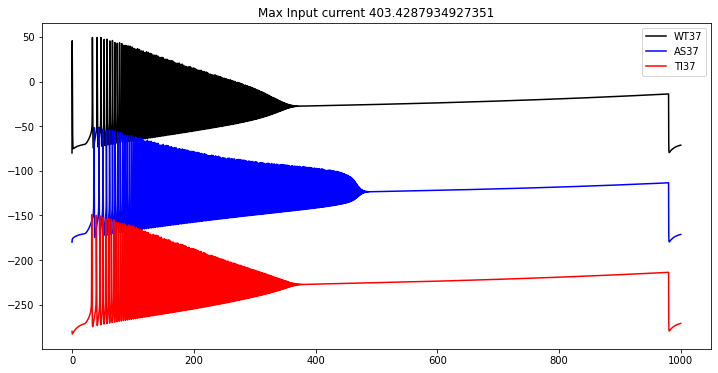

In [5]:


# set_matplotlib_formats('svg')
# plot_bifurcation(Vy_fwd, Vy_bwd, I_fwd, I_bwd, ctyp, direction=[0,1])
# plt.savefig('test.pdf')
# files.download('test.pdf')
plot_timeseries(Vy, i_scl, ctyp)
# plot_phasespace(Vy_fwd, I_fwd, ctyp, ['m_Na', 'h_Na'])




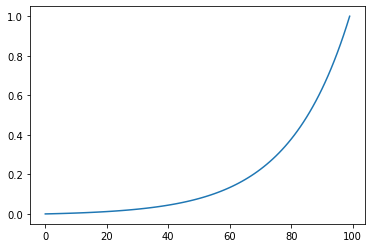

In [8]:
plt.plot((np.exp(np.linspace(0,5,100))-1) / (np.exp(5)-1))

In [33]:
np.exp(1)

2.718281828459045